In [ ]:
# download the metadata for all images, 50000 train images, 50000 test images
from huggingface_hub import snapshot_download
snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=['images/train/00.zip','images/test/00.zip','*.csv'], repo_type='dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/116M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

'/content/datasets/osv5m'

In [ ]:
# extract zips
import os
import zipfile
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                zip_ref.extractall(root)
                os.remove(os.path.join(root, file))


In [67]:
import torch
import numpy as np
import pandas as pd
import csv
# Haversine distance - length of an arc between two points on a sphere
# https://github.com/gastruc/osv5m/blob/main/metrics/utils.py
def haversine(pred, gt):
    # expects inputs to be np arrays in (lat, lon) format as radians
    # N x 2

    # calculate the difference in latitude and longitude between the predicted and ground truth points
    lat_diff = pred[:, 0] - gt[:, 0]
    lon_diff = pred[:, 1] - gt[:, 1]

    # calculate the haversine formula components
    lhs = torch.sin(lat_diff / 2) ** 2
    rhs = torch.cos(pred[:, 0]) * torch.cos(gt[:, 0]) * torch.sin(lon_diff / 2) ** 2
    a = lhs + rhs

    # calculate the final distance using the haversine formula
    c = 2 * torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))
    distance = 6371 * c

    return distance
davis = np.array([[43.547504,-79.662211]])
glasgow = np.array([[55.853467, -4.249420]])

davis_tensor = torch.tensor(davis, dtype=torch.float32).deg2rad()
glasgow_tensor = torch.tensor(glasgow, dtype=torch.float32).deg2rad()

haversine(davis_tensor, glasgow_tensor)

tensor([5307.1450])

In [ ]:
def predict_utm(image_id) -> list[float]:
  # returns the predicted latitude and longitude of a given image
  return [43.547504,-79.662211]

In [ ]:
# https://github.com/gastruc/osv5m/blob/main/metrics/distance_based.py
def geoscore(distance):
  return 5000 * torch.exp(-distance / 1492.7)

In [ ]:
file = open('datasets/osv5m/test.csv', mode='r', newline='', encoding='utf-8')
reader = csv.reader(file)

test_gt = {}
for row in reader:
  if row[0] == 'id':
    continue
  test_gt[int(row[0])] = np.array([float(row[1]), float(row[2])])

file.close()
print(test_gt[1000055667540054])

[60.77272916 -0.83074192]


In [ ]:
# evaluate a predictor by its average geoscore on the first n images from the test set

def evaluate(predictor, n):
  test_path = '/content/datasets/osv5m/images/test/00'
  i = 0
  geoscore_value = 0
  for image_id in os.listdir(test_path):
    id = int(image_id[:image_id.index('.')])
    prediction = np.array(predictor(id))
    gt = test_gt[id]

    prediction_torch = torch.tensor(prediction.reshape(1,2), dtype=torch.float32).deg2rad()
    test_gt_torch = torch.tensor(gt.reshape(1,2), dtype=torch.float32).deg2rad()

    distance = haversine(prediction_torch, test_gt_torch)
    geoscore_value += geoscore(distance)
    i += 1
    if i == n:
      break
  return geoscore_value / n

print("avg geoscore: ",evaluate(predict_utm, 10000).item())

avg geoscore:  317.4543762207031


In [33]:
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

from tqdm.notebook import trange, tqdm
from time import sleep
import csv
import numpy as np

In [89]:
# Blocks below contain some code generated with deepseek R1 with the following prompt:
# "write a pytorch model in jupyter format to classify outdoor images by their latitude and longitude"

# Step 2: Define the custom dataset

MAX_FILES = 5000

class ImageCoordinateDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = []
        self.files = [f.replace('.jpg', '') for f in listdir(image_dir) if isfile(join(image_dir, f))]
        df = pd.read_csv('datasets/osv5m/test.csv')
        row_count, column_count = df.shape
        with open ('datasets/osv5m/test.csv','r') as csv_file:
          reader = csv.reader(csv_file)
          next(reader)

          i = 0
          for row in tqdm(reader, total=MAX_FILES, desc='Processing files'):
          # Uncomment to go through all files
          # for row in tqdm(reader, total=row_count, desc='Processing files'):
            if i == MAX_FILES:
              break
            i+=1
            if row[0] == 'id':
              continue
            if str(row[0]) in self.files:
              self.data.append(np.array([str(row[0]), float(row[1]), float(row[2])]))
        self.image_dir = image_dir
        self.transform = transform
        print(f'Dataset ready, {len(self.data)} files.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f"{self.data[idx][0]}.jpg")
        image = Image.open(img_name).convert('RGB')
        coordinates = (float(self.data[idx][1]), float(self.data[idx][2]))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coordinates, dtype=torch.float32)


In [84]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [91]:
dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', \
                                 image_dir='/content/datasets/osv5m/images/test/00', \
                                 transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# print(dataset[0])

Processing files:   0%|          | 0/5000 [00:00<?, ?it/s]

Dataset ready, 1229 files.


In [86]:
# Step 5: Define the model
class GeoLocationModel(nn.Module):
    def __init__(self):
        super(GeoLocationModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = GeoLocationModel()

In [87]:
# Step 6: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
# Step 7: Train the model
num_epochs = 5
for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
  for images, coordinates in tqdm(dataloader, total=len(dataloader), desc=f'Epoch {epoch + 1} progress'):
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, coordinates)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 progress:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1/5], Loss: 3495.8376


Epoch 2 progress:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2/5], Loss: 3574.1411


Epoch 3 progress:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3/5], Loss: 3946.0571


Epoch 4 progress:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4/5], Loss: 2377.7869


Epoch 5 progress:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5/5], Loss: 1337.9824


In [ ]:
# Step 8: Save the model
# torch.save(model.state_dict(), 'geolocation_model.pth')

In [98]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=['images/test/01.zip','images/test/01.zip','*.csv'], repo_type='dataset')

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

01.zip:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

'/content/datasets/osv5m'

In [100]:
import os
import zipfile
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                zip_ref.extractall(root)
                os.remove(os.path.join(root, file))

In [101]:
val_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', \
                                 image_dir='/content/datasets/osv5m/images/test/01', \
                                 transform=transform)
val_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Processing files:   0%|          | 0/5000 [00:00<?, ?it/s]

Dataset ready, 1157 files.


In [102]:
# Model: deepseek r1
# Prompt: now write code to validate this

# Step 3: Load the trained model
# model = GeoLocationModel()
# model.load_state_dict(torch.load('geolocation_model.pth'))
model.eval()  # Set the model to evaluation mode

GeoLocationModel(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [103]:
# Step 4: Validate the model
val_loss = 0.0
val_mae = 0.0
criterion = nn.MSELoss()  # Use MSE for loss calculation
mae_criterion = nn.L1Loss()  # Use MAE for error calculation

In [104]:
batch_val_losses = []
batch_val_mae = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates in tqdm(val_dataloader, total=len(dataloader), desc=f'Validating'):
        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, coordinates)
        val_loss += loss.item()

        # Calculate MAE
        mae = mae_criterion(outputs, coordinates)
        val_mae += mae.item()

        # Store batch-wise loss and MAE
        batch_val_losses.append(loss.item())
        batch_val_mae.append(mae.item())

# Calculate average loss and MAE
val_loss /= len(val_dataloader)
val_mae /= len(val_dataloader)

print(f'Validation Loss (MSE): {val_loss:.4f}')
print(f'Validation MAE: {val_mae:.4f}')

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Validation Loss (MSE): 2047.6647
Validation MAE: 34.4974


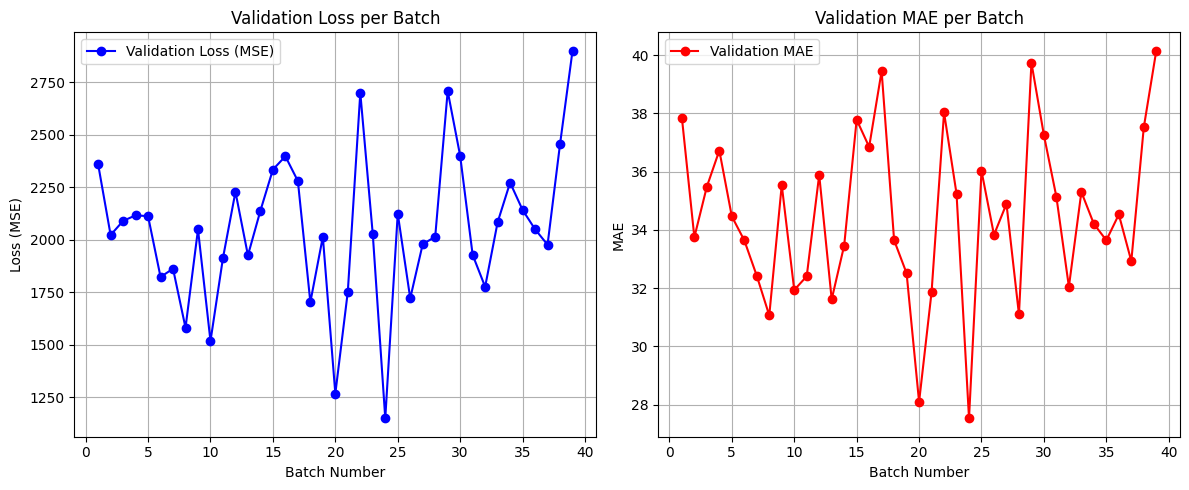

In [105]:
# Model: deepseek r1
# Prompt: write matplotlib code to plot previous validation loop:

import matplotlib.pyplot as plt

# Step 1: Plot Validation Loss per Batch
plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(batch_val_losses) + 1), batch_val_losses, label='Validation Loss (MSE)', color='blue', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Loss (MSE)')
plt.title('Validation Loss per Batch')
plt.legend()
plt.grid(True)

# Step 2: Plot Validation MAE per Batch
plt.subplot(1, 2, 2)
plt.plot(range(1, len(batch_val_mae) + 1), batch_val_mae, label='Validation MAE', color='red', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('MAE')
plt.title('Validation MAE per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [107]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [131]:
# Step 5: Visualize some predictions (optional)
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for images, coordinates in dataloader:
            outputs = model(images)
            for i in range(min(num_samples, len(images))):
                pred_lat, pred_lon = outputs[i].numpy()
                true_lat, true_lon = coordinates[i].numpy()

                haver_err = haversine(
                                      torch.tensor(np.array([[pred_lat, pred_lon]]), dtype=torch.float32).deg2rad(),
                                      torch.tensor(np.array([[true_lat, true_lon]]), dtype=torch.float32).deg2rad(),
                                      )

                print(f'Sample {i+1}:')
                print(f'  Predicted: Latitude = {pred_lat:.4f}, Longitude = {pred_lon:.4f}')
                print(f'  True:      Latitude = {true_lat:.4f}, Longitude = {true_lon:.4f}')
                print(f'haversine: {haver_err}')

                # Display the image
                img = images[i].permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Reverse normalization
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f'Pred: ({pred_lat:.4f}, {pred_lon:.4f})\nTrue: ({true_lat:.4f}, {true_lon:.4f})')
                plt.axis('off')

                # World map for better understanding of how bad our prediction is
                geometry = [Point(pred_lat, pred_lon), Point(true_lat, true_lon)]
                geo_df = GeoDataFrame(geometry = geometry)
                url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
                world = gpd.read_file(url)
                geo_df.plot(ax=world.plot(color="lightgrey", figsize=(10, 6)), marker='x', c=['red', 'green'], markersize=50);

                plt.show()
            break

Sample 1:
  Predicted: Latitude = 13.6336, Longitude = 38.5193
  True:      Latitude = 30.2960, Longitude = 31.6245
haversine: tensor([1983.1584])


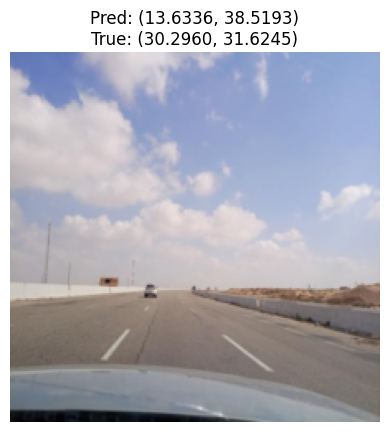

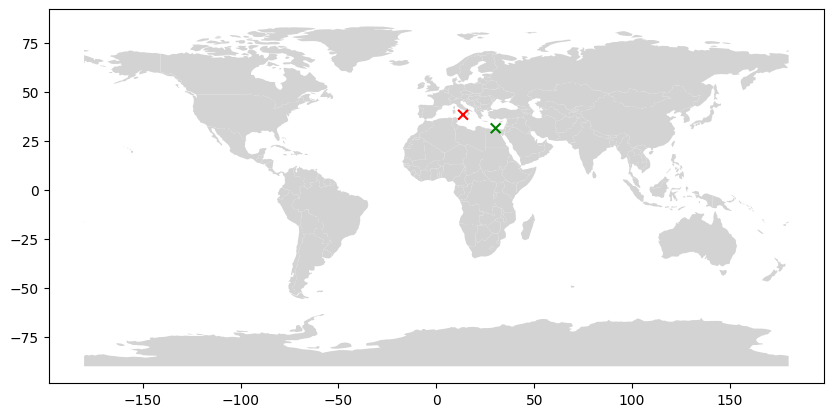

Sample 2:
  Predicted: Latitude = 5.8764, Longitude = 22.9153
  True:      Latitude = 34.1790, Longitude = -1.2245
haversine: tensor([4008.7217])


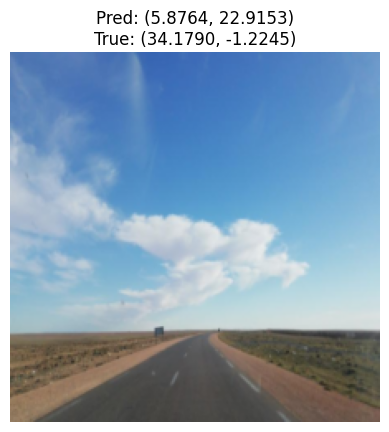

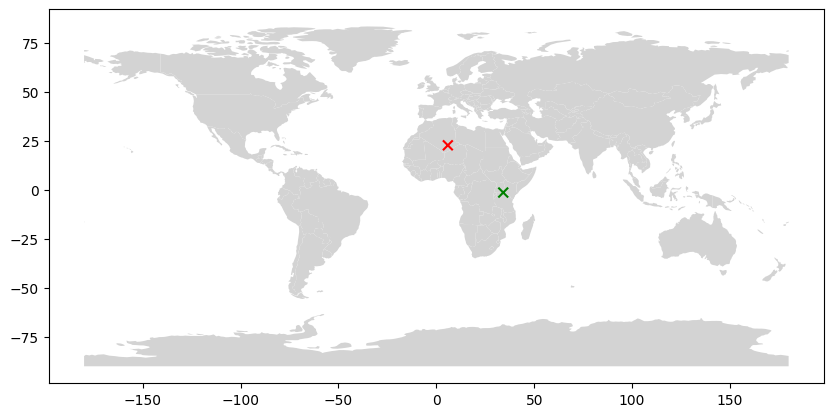

Sample 3:
  Predicted: Latitude = 14.7300, Longitude = -13.1314
  True:      Latitude = 23.6388, Longitude = -105.8210
haversine: tensor([9622.6406])


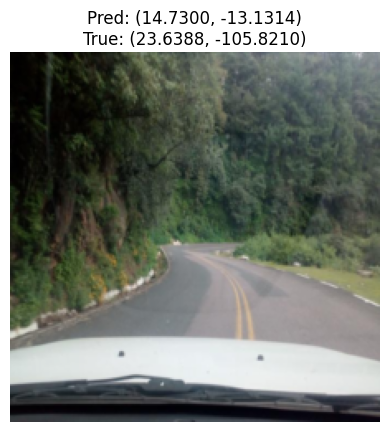

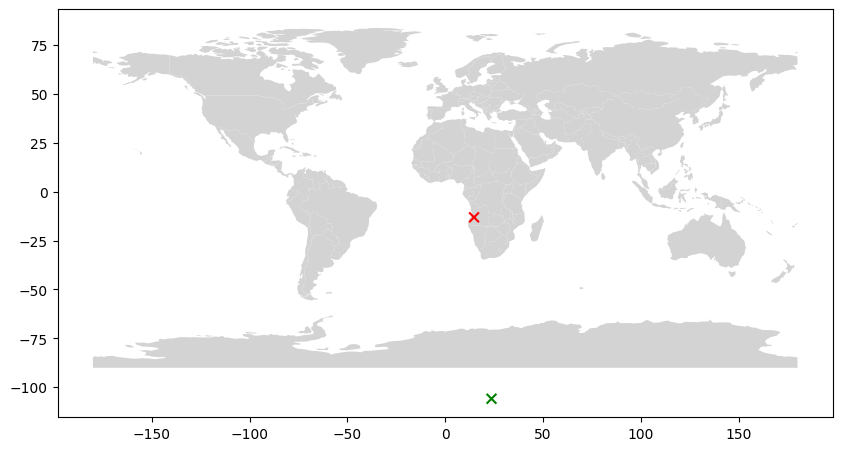

Sample 4:
  Predicted: Latitude = -6.3853, Longitude = 106.8297
  True:      Latitude = -24.0003, Longitude = 149.8145
haversine: tensor([4983.2827])


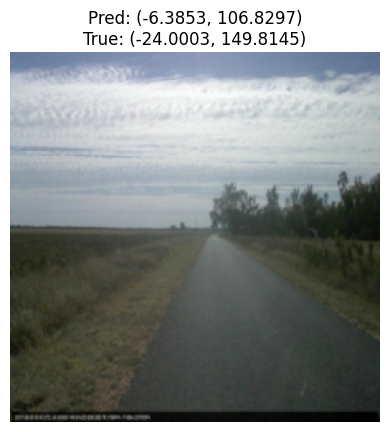

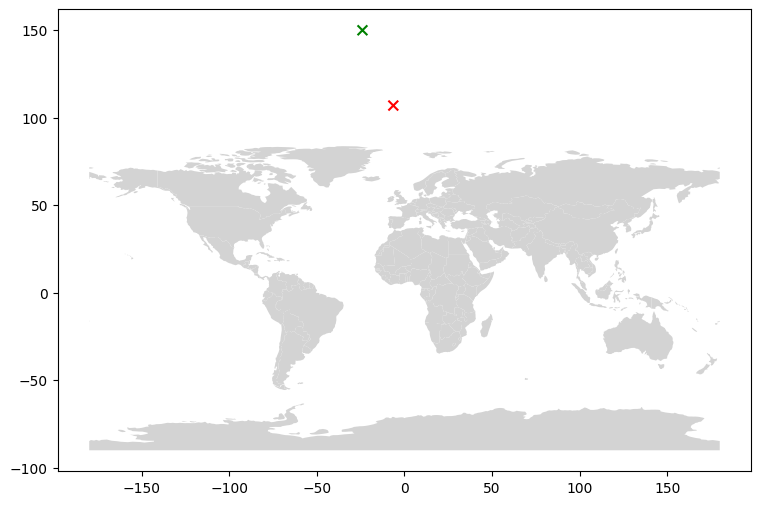

Sample 5:
  Predicted: Latitude = 28.7671, Longitude = 30.2868
  True:      Latitude = 30.6520, Longitude = 104.1428
haversine: tensor([6997.8198])


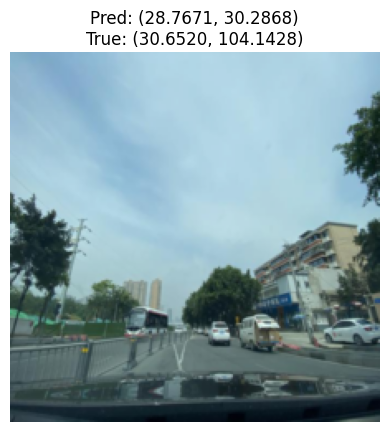

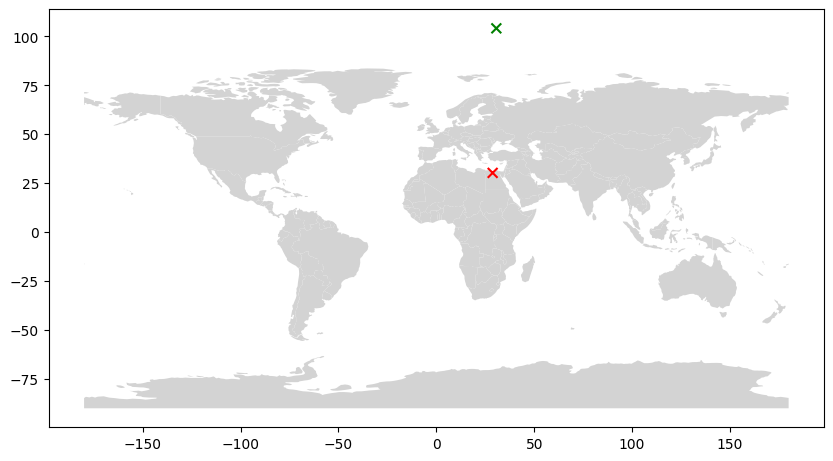

In [130]:
# Plot some predictions
plot_predictions(model, val_dataloader, num_samples=5)